#### model = Concat signatures with pose -> Dense -> softmax with 100 classes. 
#### run model for each frame in a seq, and then take majority vote

In [2]:
from data import *

In [3]:
pose_paths, keypoints, scores = read_pose('data/pose.pkl')
signatures_paths, signatures = read_signatures('data/signatures.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'data/pose.pkl'

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

IMAGE_DIM = 64
NUM_CLASSES = 100
learning_rate = 1e-4
epochs = 500
INPUT_DIM = 2048 # signatures[0].shape[0]


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(IMAGE_DIM * IMAGE_DIM, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, NUM_CLASSES)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)
    
net = Net()
print(net)

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.NLLLoss()

Net(
  (fc1): Linear(in_features=4096, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
)


In [5]:
# from tqdm import tqdm
# for t in tqdm(range(epochs)):
#     y_pred = net(x)
#     loss = loss_fn(y_pred, y)
#     if t % 100 == 99:
#         print(t, loss.item())
#     model.zero_grad()
#     loss.backward()
#     optimizer.step()

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.models as models
import os
DATA_DIR = 'data/'
TEST_DIR = 'test_data/'
REAL_DIR = 'real_data/'
IMAGES_FILE = 'images.tar'
POSE_FILE = 'pose.pkl'
SIGNATURES_FILE = 'signatures.pkl'

In [17]:
class OrcamDataset(Dataset):
    def __init__(self, data_dir, train=True, filter_signatures=True):
        self.data_dir = data_dir
        im_file = os.path.join(data_dir, IMAGES_FILE)
        pose_file = os.path.join(data_dir, POSE_FILE)
        sig_file = os.path.join(data_dir, SIGNATURES_FILE)
        self.pose_paths, self.keypoints, self.scores = read_pose(pose_file)
        self.signatures_paths, self.signatures = read_signatures(sig_file)
        self.signatures = torch.Tensor(self.signatures)
        self.images = Images(im_file)
        if filter_signatures:
            self.actual_paths = list(set(self.images.paths) & set(self.signatures_paths))
        else:
            raise NotImplementedErrorׂ('Should add pretrained net instead of sig')
            self.actual_paths = self.images.paths
    
    def __len__(self):
        return len(self.actual_paths)
    
    @staticmethod
    def get_pose_dists(pose):
        return torch.Tensor([x for x in np.array([np.sqrt(sum((kp_1 - kp_2) ** 2, 0)) for kp_1 in pose for kp_2 in pose]) if x != 0])

    @staticmethod
    def get_label(path):
        slash = path.find('/')
        underscore = path.find('_')
        num_str = path[underscore + 1:slash]
        return int(num_str)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.actual_paths[idx]
        sign_idx = self.signatures_paths.index(path)
        signature = self.signatures[sign_idx]
        pose_idx = self.pose_paths.index(path)
        pose = self.keypoints[pose_idx]
        image = self.images[path]
        image = torch.Tensor(image.copy())
        label = self.get_label(path)
        pose_dist = self.get_pose_dists(pose)
        sample = {'image': image, "signature": signature, "pose": pose_dist, "label": torch.Tensor([label])}
        return sample


In [18]:
import matplotlib.pyplot as plt
dataset = OrcamDataset(REAL_DIR, train=True)
dataload = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=1)

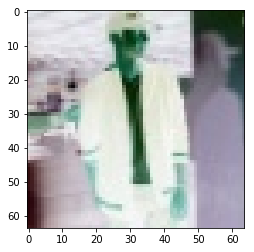

In [21]:
#test dataset
n = 10
for i in range(n):
    sample = dataset[i]
    img = sample['image']
    plt.imshow(img)
    break
    ax = plt.subplot(1, n, i+1)
    plt.tight_layout()
    ax.set_title('#{}'.format(i))
    ax.axis('off')
    plt.imshow(img)

tensor([[[ 60.,  56.,  57.],
         [ 48.,  44.,  45.],
         [ 56.,  52.,  53.],
         ...,
         [ 43.,  23.,  22.],
         [ 43.,  23.,  22.],
         [ 42.,  22.,  21.]],

        [[ 52.,  48.,  49.],
         [ 47.,  43.,  44.],
         [ 54.,  50.,  51.],
         ...,
         [ 20.,   0.,   0.],
         [ 19.,   0.,   0.],
         [ 18.,   0.,   0.]],

        [[ 49.,  45.,  46.],
         [ 52.,  48.,  49.],
         [ 54.,  50.,  51.],
         ...,
         [ 31.,  10.,   7.],
         [ 30.,   9.,   6.],
         [ 29.,   8.,   5.]],

        ...,

        [[ 25.,  32.,  48.],
         [ 27.,  34.,  50.],
         [ 27.,  34.,  50.],
         ...,
         [ 12.,   7.,  37.],
         [ 35.,  27.,  64.],
         [ 80.,  72., 113.]],

        [[ 23.,  32.,  49.],
         [ 27.,  36.,  53.],
         [ 29.,  38.,  55.],
         ...,
         [ 28.,  15.,  43.],
         [ 11.,   3.,  40.],
         [  4.,   0.,  40.]],

        [[ 26.,  34.,  53.],
       

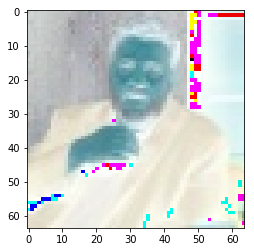

In [22]:
n = 10
for i, batch in enumerate(dataload):
    if i == 1:
        break
    # break
    img = batch['image'][0]
    print(img)
    plt.imshow(img)
    print(batch['image'].size())
    
    print(batch['signature'].size())
    print(batch['pose'].size())
#     ax = plt.subplot(1, n, i+1)
#     plt.tight_layout()
#     ax.set_title('#{}'.format(i))
#     ax.axis('off')
#     plt.imshow(image)
    
    

In [14]:
    #try load test data
    data_dir = TEST_DIR
    im_file = os.path.join(data_dir, IMAGES_FILE)
    pose_file = os.path.join(data_dir, POSE_FILE)
    sig_file = os.path.join(data_dir, SIGNATURES_FILE)
    pose_paths, keypoints, scores = read_pose(pose_file)
    signatures_paths, signatures = read_signatures(sig_file)
    signatures = torch.Tensor(signatures)
    images = Images(im_file)

Indexing tar file, this could take a few minutes...
done


In [16]:
print(images.paths[:10])

['seq_0000/frame_0000', 'seq_0000/frame_0001', 'seq_0000/frame_0002', 'seq_0000/frame_0003', 'seq_0000/frame_0004', 'seq_0000/frame_0005', 'seq_0000/frame_0006', 'seq_0000/frame_0007', 'seq_0000/frame_0008', 'seq_0000/frame_0009']


In [ ]:
print('hey')


